In [1]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
df_test = pd.read_json('test.json')
df_train = pd.read_json('train.json')

## EDA

In [2]:
cs_list = df_train["cuisine"].unique()
print("Number of cuisine: {}".format(len(cs_list)))
print(cs_list)

ing_count = set()
for x in df_train['ingredients']:
    for y in x:
        ing_count.add(y)
ing_count_list = list(ing_count)
print("\nNumber of ingredients: {}".format(len(ing_count)))

Number of cuisine: 20
['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']

Number of ingredients: 6714


In [3]:
# import pandas as pd
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6,9))    # 顯示圖框架大小

# labels = accident["reason of car accident"]      # 製作圓餅圖的類別標籤
# separeted = (0, 0, 0.3, 0, 0.3)                  # 依據類別數量，分別設定要突出的區塊
# size = accident["count"]                         # 製作圓餅圖的數值來源

# plt.pie(size,                           # 數值
#         labels = labels,                # 標籤
#         autopct = "%1.1f%%",            # 將數值百分比並留到小數點一位
#         explode = separeted,            # 設定分隔的區塊位置
#         pctdistance = 0.6,              # 數字距圓心的距離
#         textprops = {"fontsize" : 12},  # 文字大小
#         shadow=True)                    # 設定陰影

 
# plt.axis('equal')                                          # 使圓餅圖比例相等
# plt.title("Pie chart of car accident", {"fontsize" : 18})  # 設定標題及其文字大小
# plt.legend(loc = "best")                                   # 設定圖例及其位置為最佳

# plt.savefig("Pie chart of car accident.jpg",   # 儲存圖檔
#             bbox_inches='tight',               # 去除座標軸占用的空間
#             pad_inches=0.0)                    # 去除所有白邊
# plt.close()      # 關閉圖表

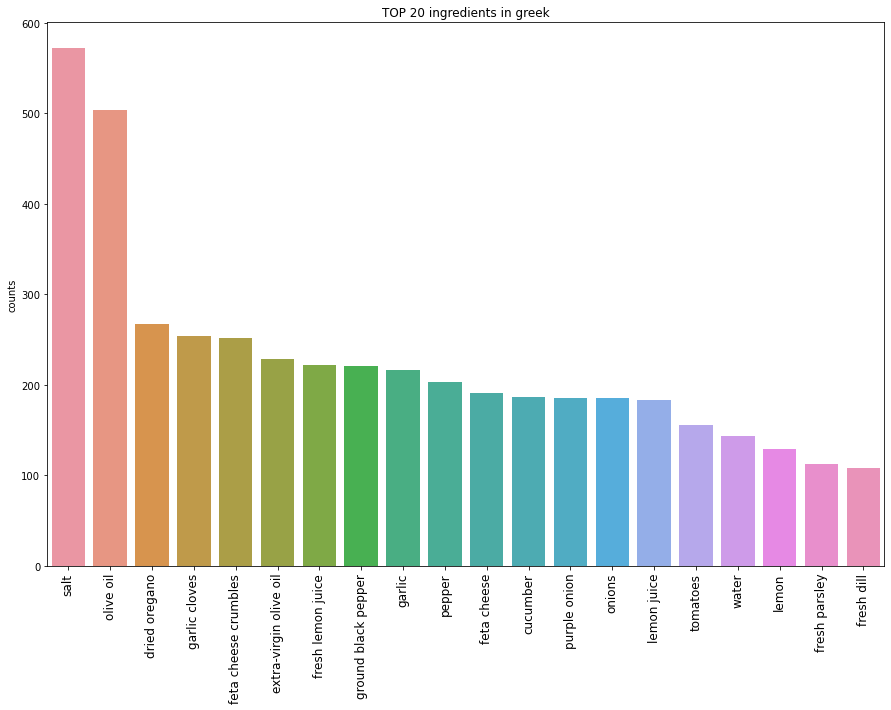

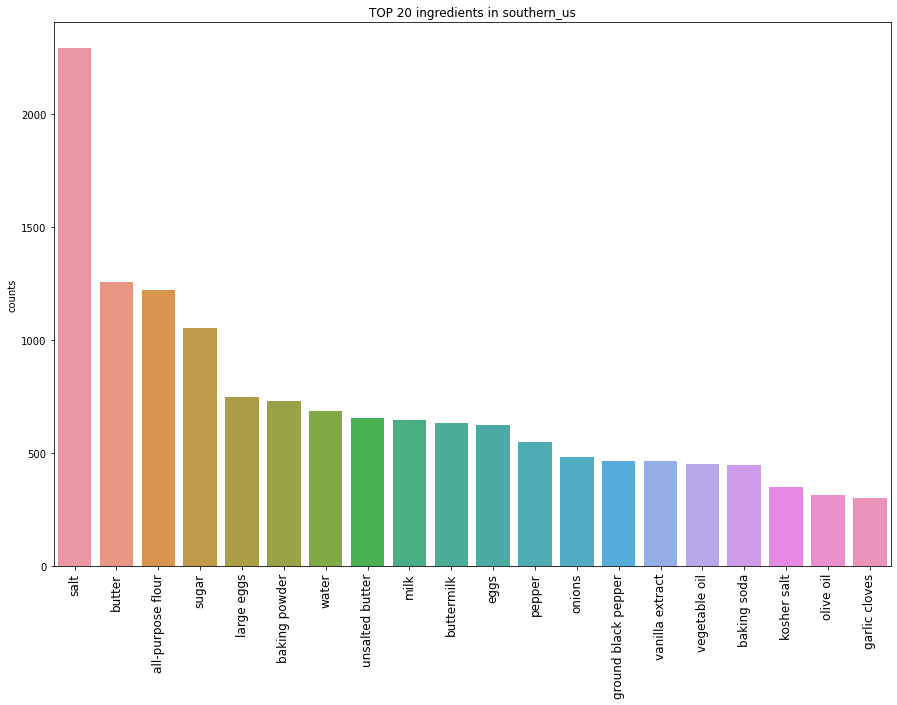

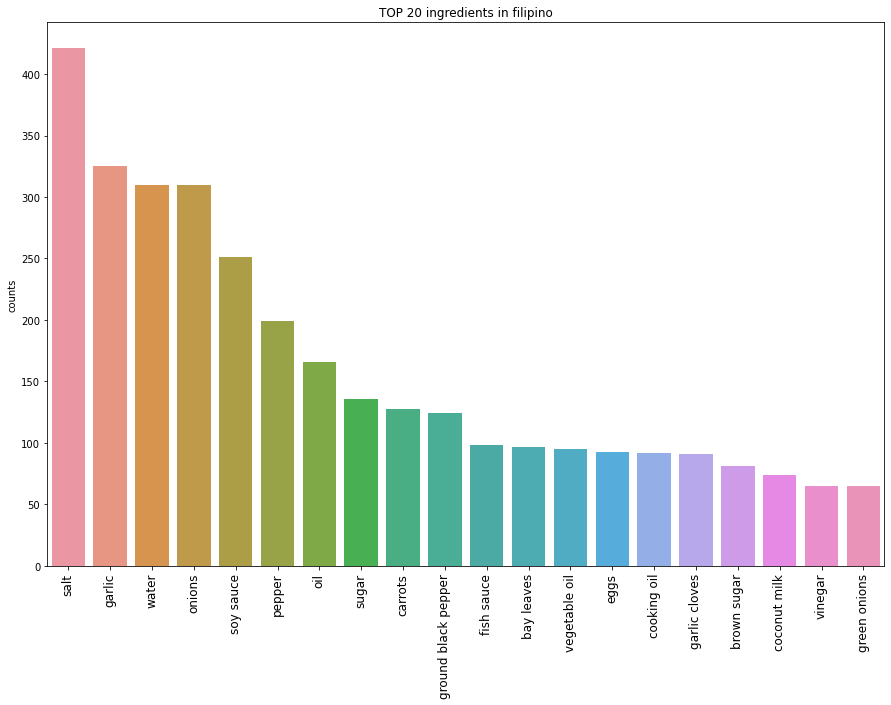

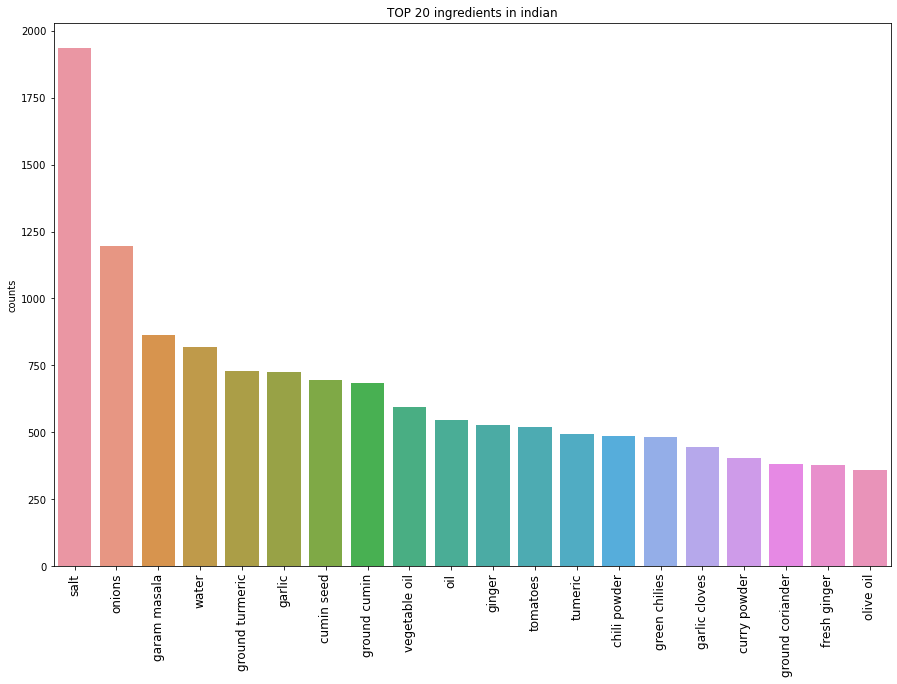

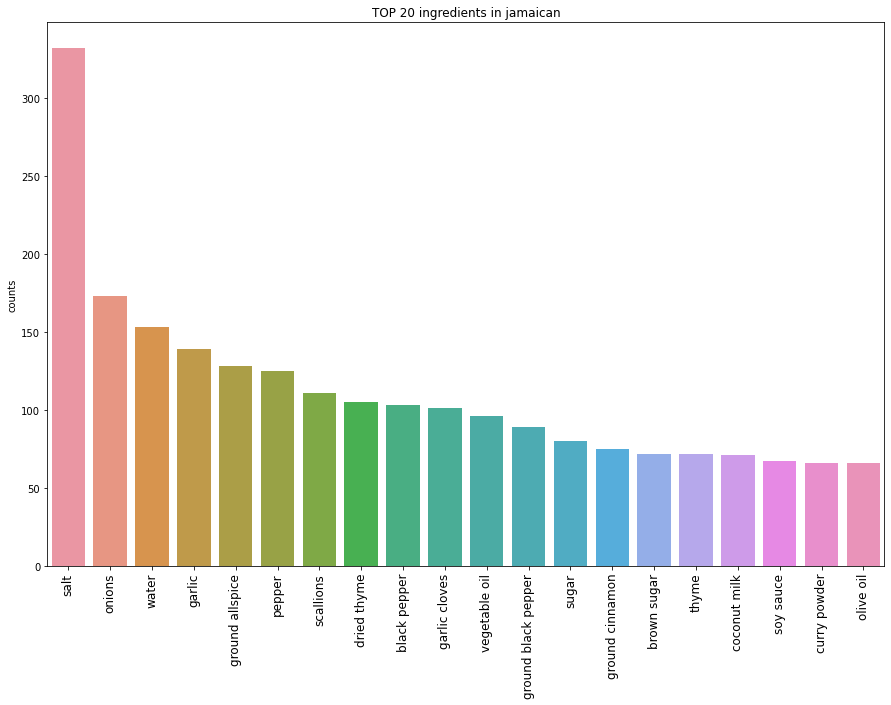

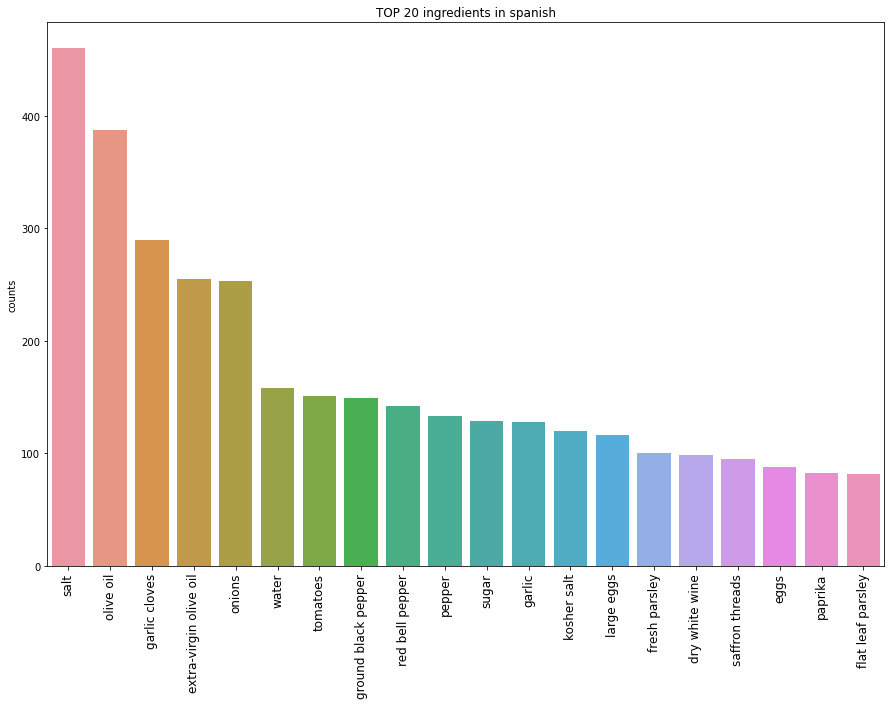

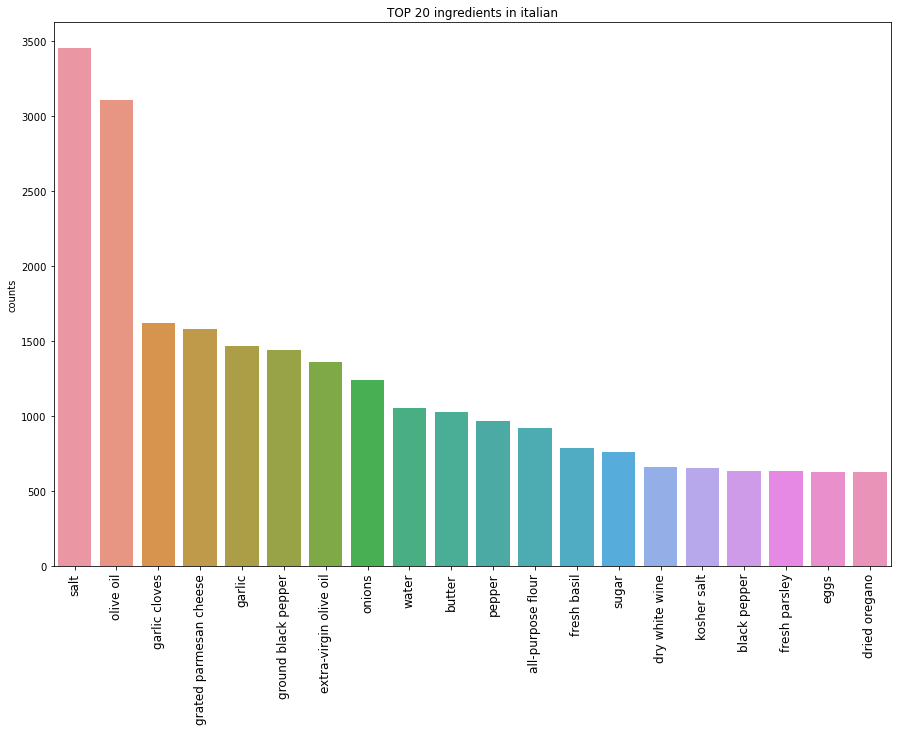

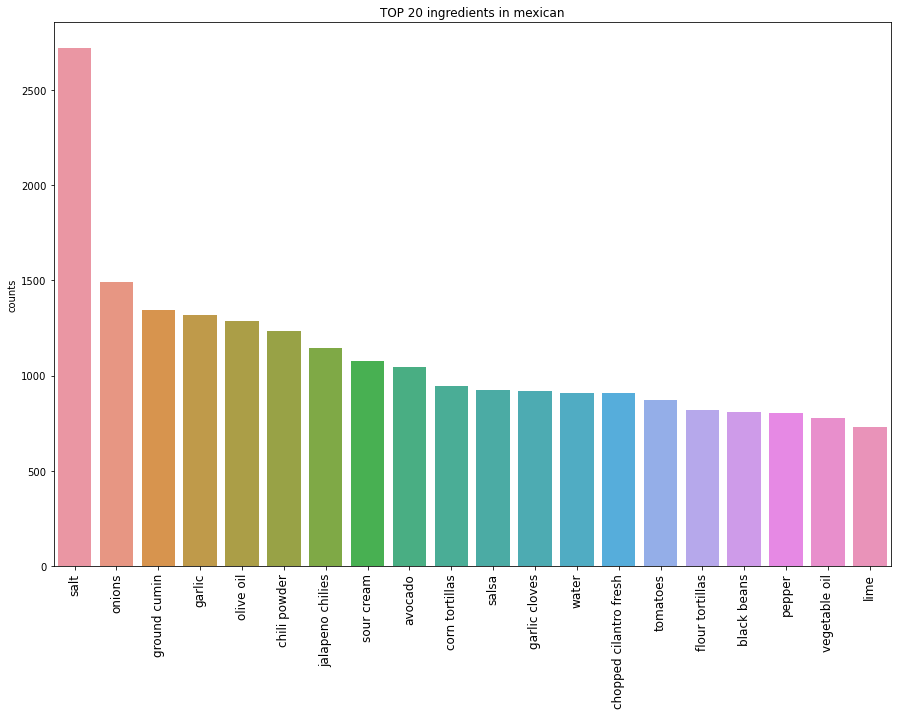

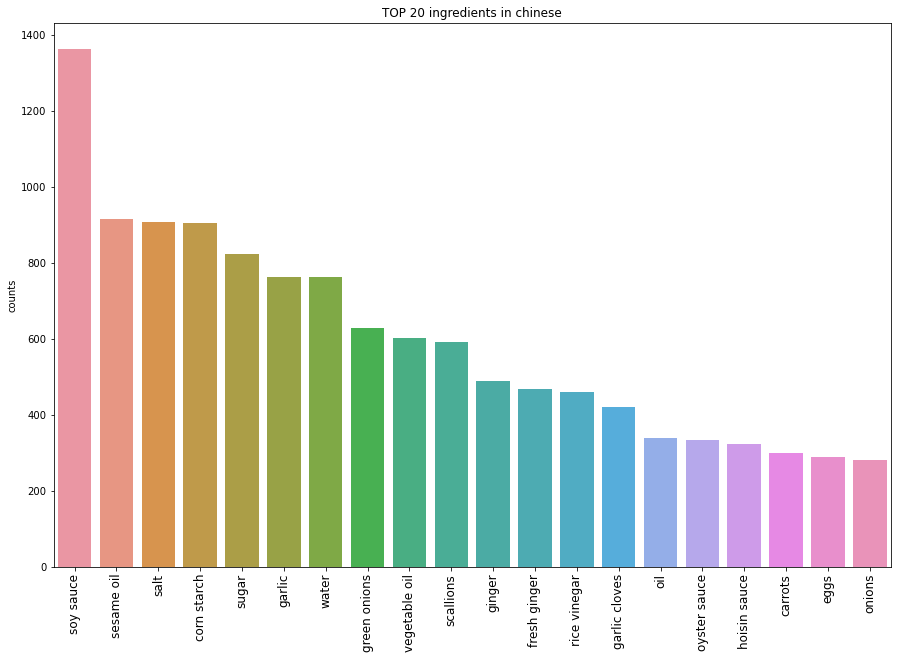

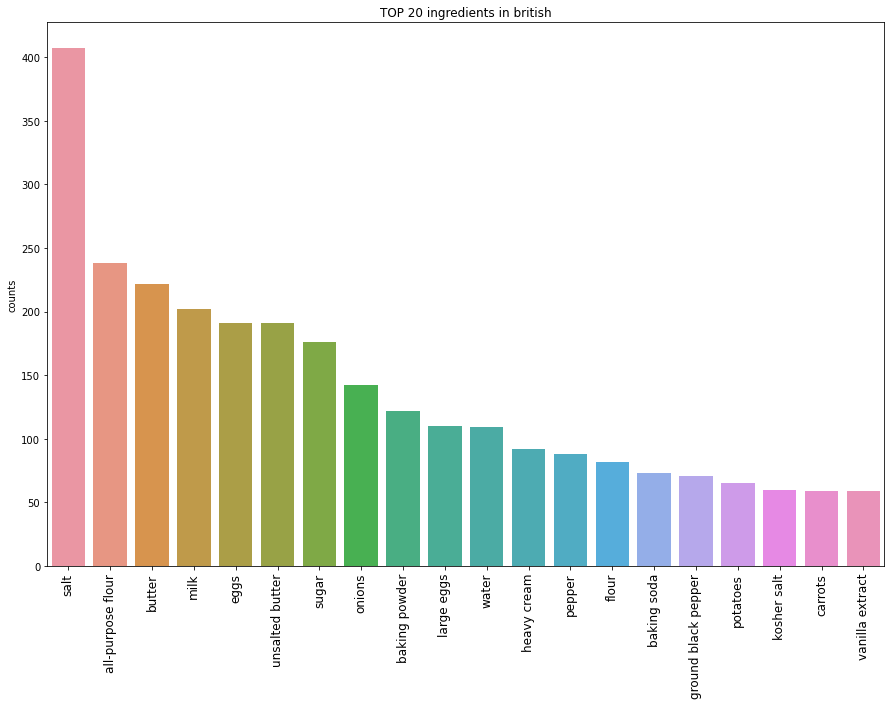

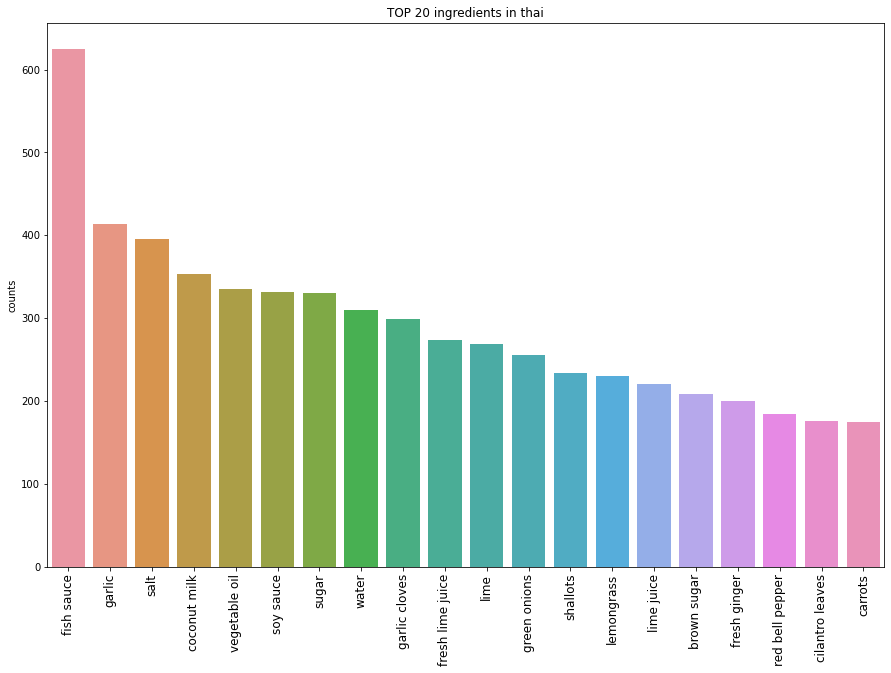

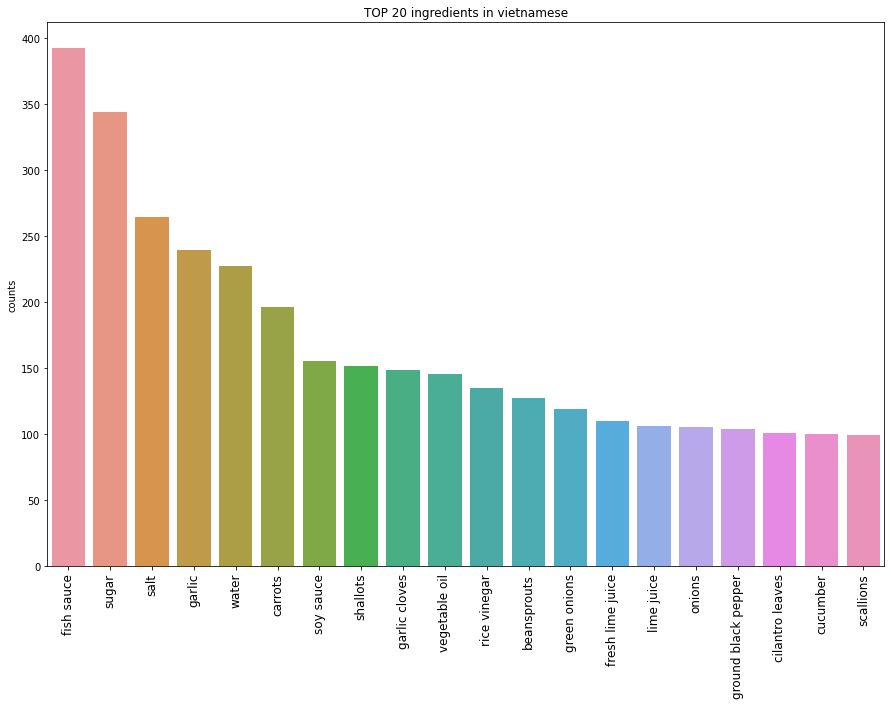

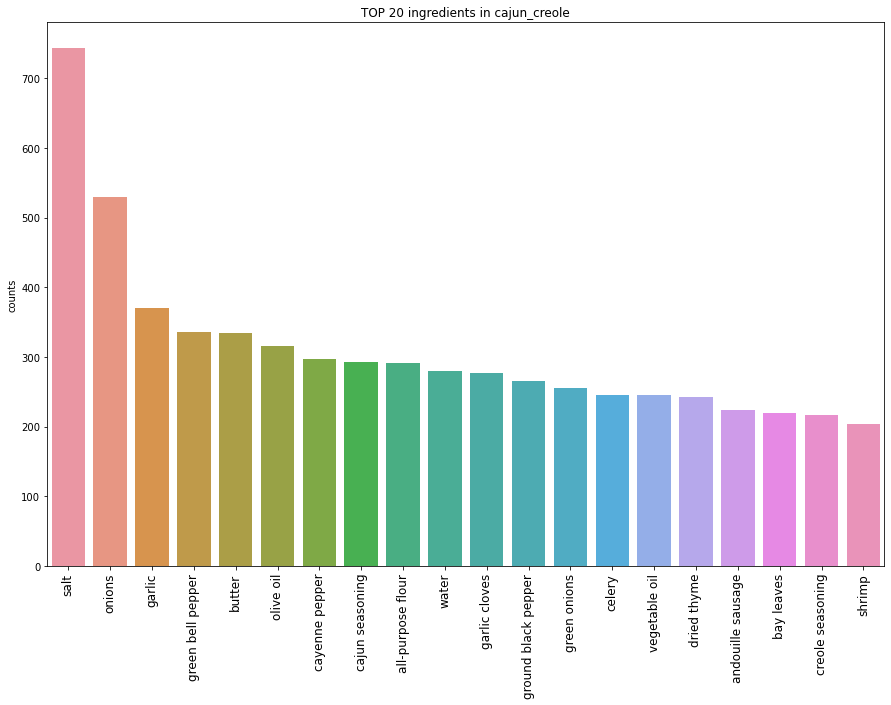

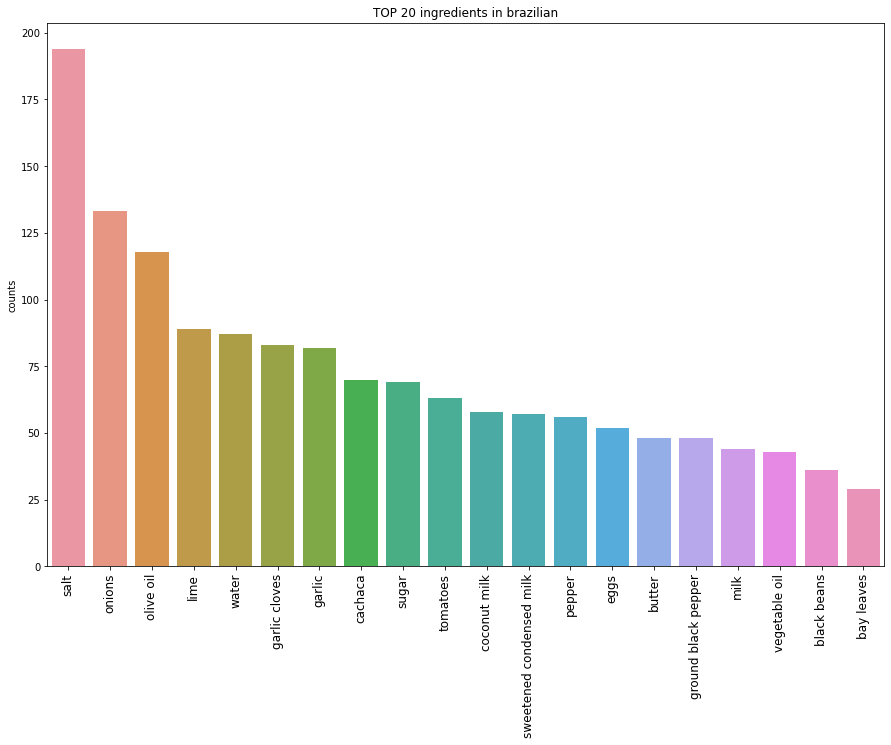

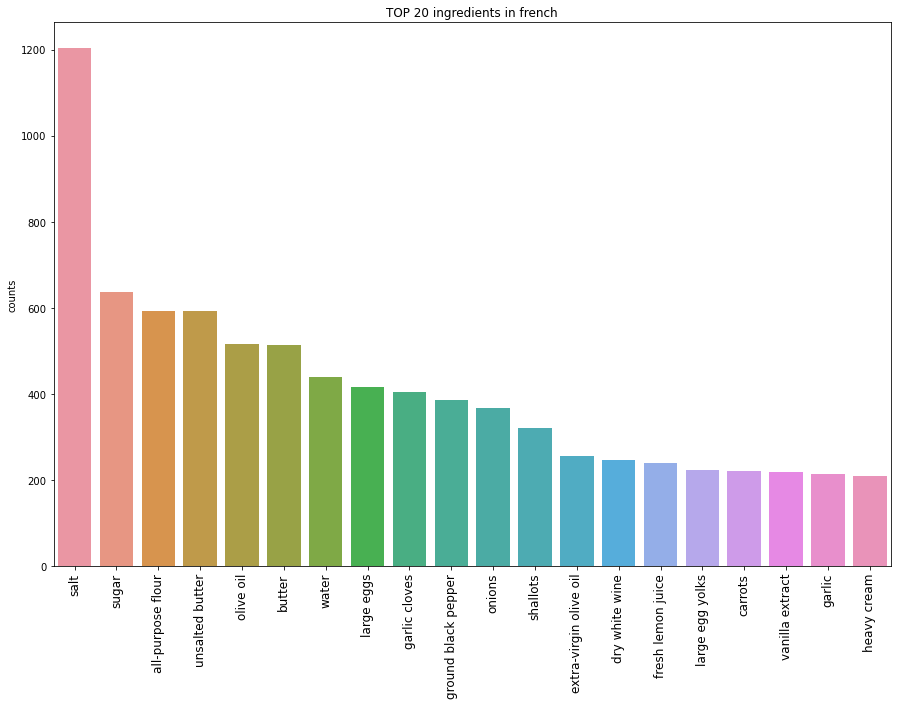

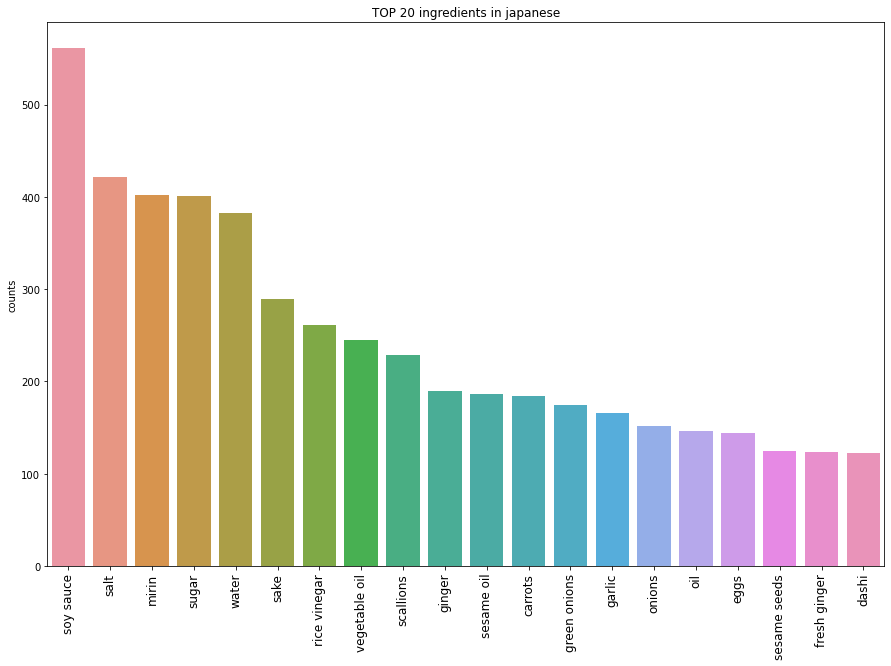

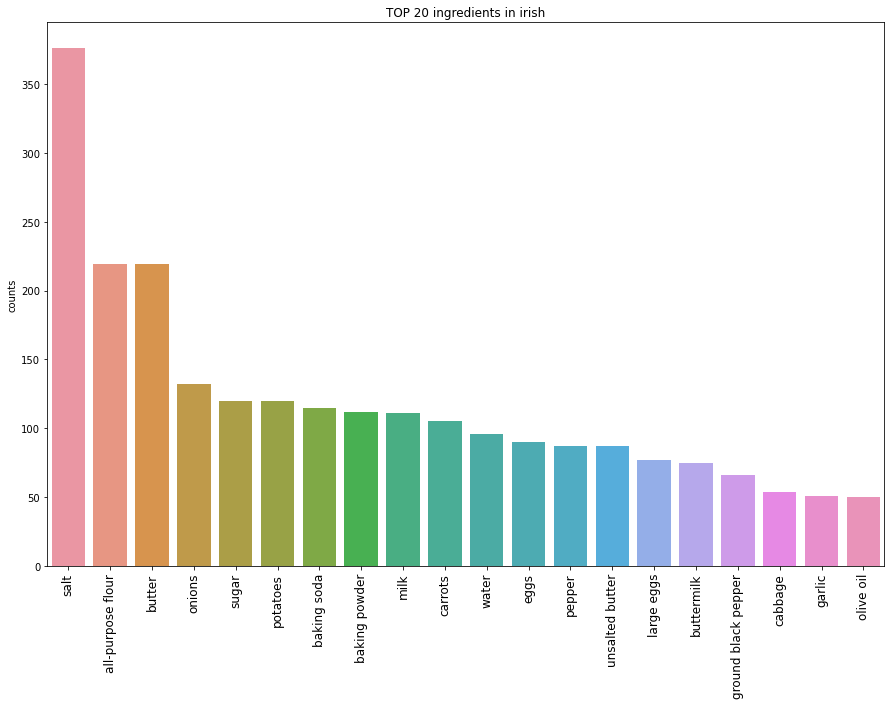

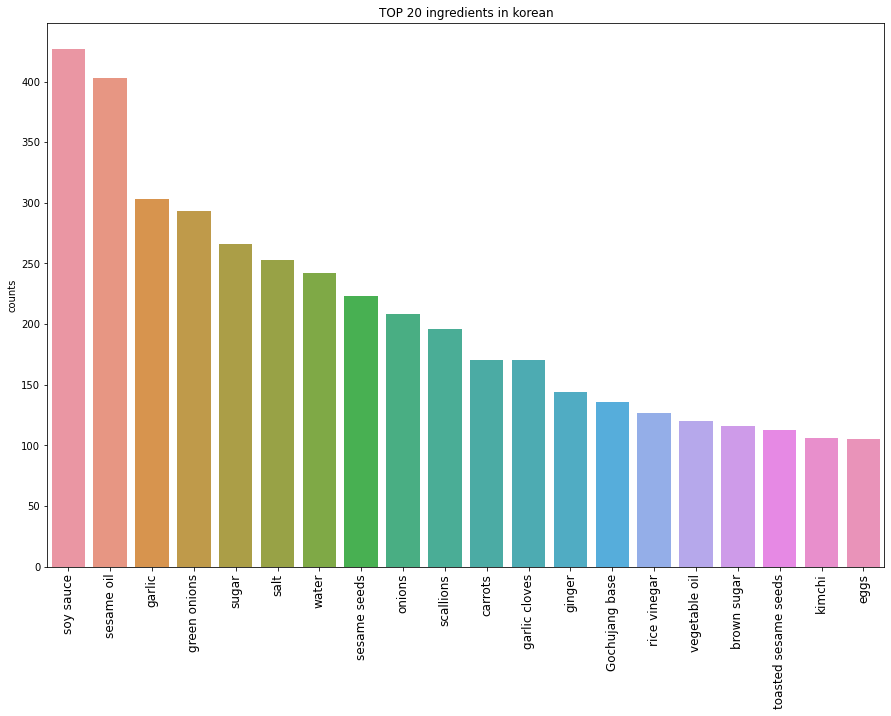

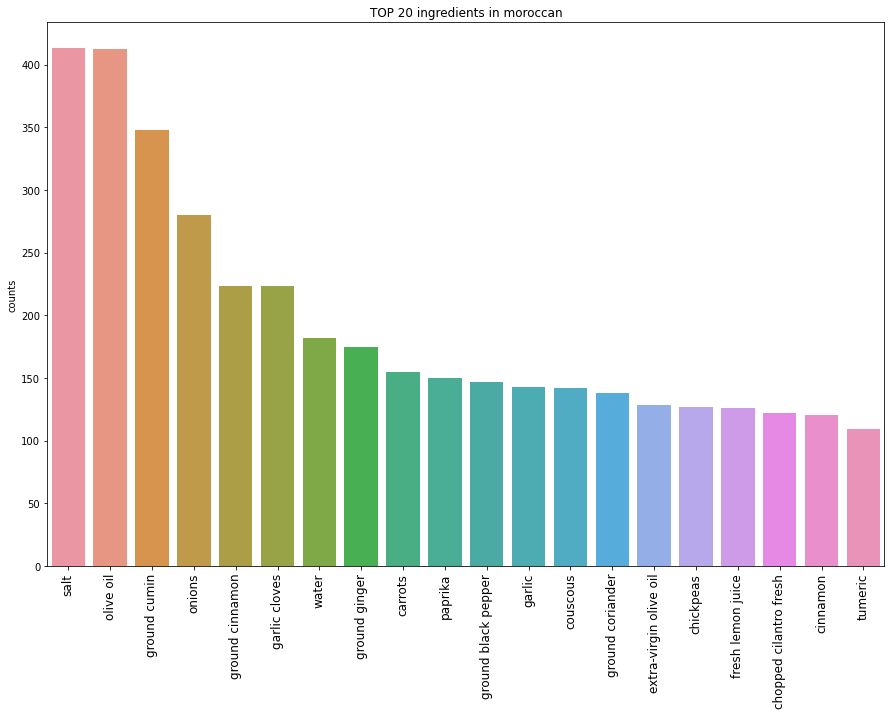

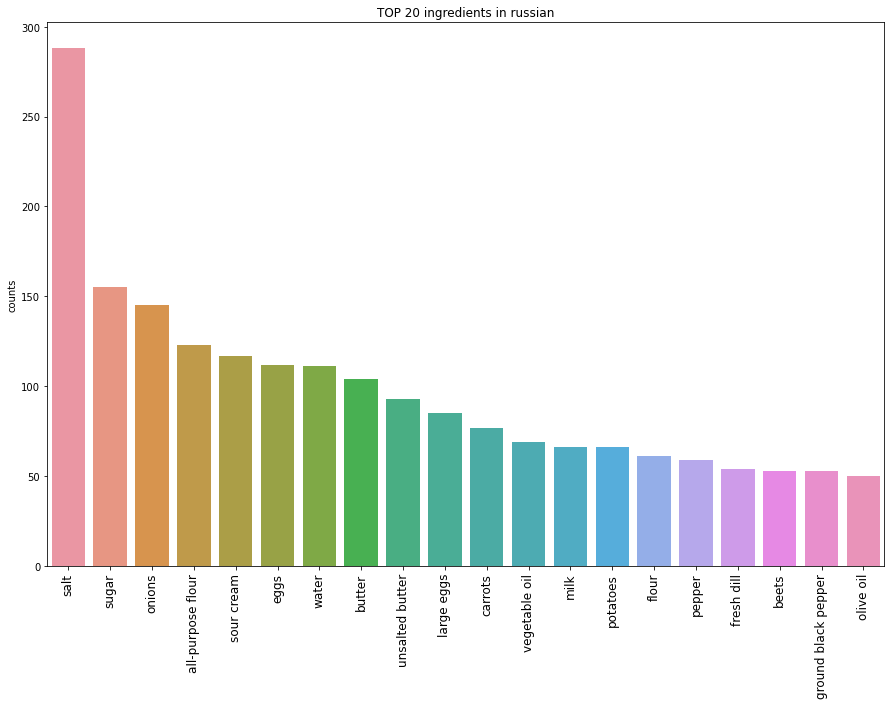

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_cuisine(df_train,country):
    all_ingredients = dict()
    df=df_train.copy()
    df = df[df['cuisine']==country]
    for per_cuisine in df['ingredients']:
        for per_ingredient in per_cuisine:
            if (per_ingredient in all_ingredients):
                all_ingredients[per_ingredient]+=1
            else:
                all_ingredients[per_ingredient]=1

    all_ingredients = dict(sorted(all_ingredients.items(), key=lambda all_ingredients: all_ingredients[1],reverse=True)[:20]) 
    all_ingredients_df= pd.DataFrame.from_dict(all_ingredients, orient='index').rename(columns={0:'counts'})
    # all_ingredients_df.sort_values(by=['counts'],ascending=False,inplace=True)
    plt.figure(figsize = (15,10))
    sns.barplot(x=all_ingredients_df['counts'][0:20].index,y=all_ingredients_df['counts'][0:20])
    plt.xticks(rotation = 90,fontsize = 12)
    plt.title('TOP 20 ingredients in {}'.format(country))
    # plt.savefig('.\eda\{}.png'.format(country),bbox_inches='tight')
    # plt.close()
    
    return all_ingredients

# EDA plot ,and save dict. to all ingredients in different country 
data = dict() # dict['country']['ingrdients']['counts']
for country in df_train.cuisine.unique():  
    data[country]=get_cuisine(df_train,country)


## Preprocessing

In [5]:
# preprocessing
def preprocess_df(df):
    nltk.download('wordnet')
    def process_string(x):
        x = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in x] #Lemmatization ,list of ing.
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed |crumbles |ground |minced |powder |chopped |sliced ','', x), x)) # delete 處理方式,如:粉,丁,條狀..等等
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))   # To remove everything except a-z and A-Z
        x = " ".join(x)                                 # To make list element a string element 
        x = x.lower()
        return x
    
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df


def get_cuisine_cumulated_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])

    for cus in df["cuisine"].unique():
        st = ""
        for x in df[df.cuisine == cus]['ingredients']:
            st += x
            st += " "
        cuisine_df.loc[cus,'ingredients'] = st

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})
    return cuisine_df

df = preprocess_df(df_train) # shape=(39774,2)
test_df = preprocess_df(df_test) #(9944,2)
cuisine_df = get_cuisine_cumulated_ingredients(df) # (20,total_ing)

train = df['ingredients']
target = df['cuisine']
test = test_df['ingredients']


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Test dimension

In [6]:
def tfidf_vectorizer(train, test=None):
    """
    TFiDF Vectorizer
    """
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    train = tfidf.fit_transform(train)
    if test is not None:
        test = tfidf.transform(test)
        return train, test, tfidf
    else:
        return train, tfidf

train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(train,test)
train_tfidf.shape

(39774, 2796)

## IDA -> use pipeline

In [7]:
# instantiate our pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

# set our pipeline parameters
pipe_params = {'vect__ngram_range':[(1, 1)],
               'vect__max_features':[None],
               'vect__stop_words':['english'],
               'vect__max_df':[.57],
#                'classify__C':[1],
               'decomp__n_components':[200,2002,2796]}

# instantiate our pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

pipe = Pipeline([('vect', TfidfVectorizer(token_pattern=r'\w+')),
                 ('decomp', TruncatedSVD()), 
                 ('classify', SGDClassifier(max_iter=2000, tol=1e-4))])

# LinearSVC(): 0.78891
# SVC(kernel='rbf'): 0.804
# LogisticRegression(random_state=0, max_iter=1000): 0.78509
# SGDClassifier(max_iter=1000, tol=1e-4): 0.77272

# instantiate our gridsearch object
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, pipe_params, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')
# fit the gridsearch object
grid.fit(train, target)
# get our results

print(grid.best_score_, grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   35.0s remaining:   52.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.0min finished


0.773922654256317 {'decomp__n_components': 2002, 'vect__max_df': 0.57, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}


In [8]:
y_pred = grid.predict(test)

In [9]:
test_id = df_test['id']
my_submission = pd.DataFrame({'id':test_id})
my_submission['cuisine'] = y_pred
my_submission.to_csv('submission.csv', index=False)
print('Saved file to disk as submission.csv.')

Saved file to disk as submission.csv.
